In [1]:
import pandas as pd
import os
import numpy as np
import epiweeks
import datetime

In [2]:
    cases_csv = 'https://raw.githubusercontent.com/KITmetricslab/covid19-forecast-hub-de/master/data-truth/RKI/by_age/truth_RKI-Incident%20Cases%20by%20Age_Germany.csv'
    cases = pd.read_csv(cases_csv)
    cases

,date,location,location_name,age_group,value
0,2020-03-25,GM,Germany,A00-A04,32
1,2020-03-25,GM,Germany,A05-A14,81
2,2020-03-25,GM,Germany,A15-A34,1045
3,2020-03-25,GM,Germany,A35-A59,1989
4,2020-03-25,GM,Germany,A60-A79,754
...,...,...,...,...,...
70290,2021-11-18,GM16,Berlin State,A15-A34,750
70291,2021-11-18,GM16,Berlin State,A35-A59,964
70292,2021-11-18,GM16,Berlin State,A60-A79,247
70293,2021-11-18,GM16,Berlin State,A80+,40


In [3]:
    deaths_csv = 'https://raw.githubusercontent.com/KITmetricslab/covid19-forecast-hub-de/master/data-truth/RKI/by_age/truth_RKI-Incident%20Deaths%20by%20Age_Germany.csv'
    deaths = pd.read_csv(deaths_csv)
    deaths.loc[deaths['location_name'] == 'Free State of Thuringia', 'location_name'] = 'Free State of Thüringia'
    deaths

,date,location,location_name,age_group,value
0,2020-03-25,GM,Germany,A00-A04,0
1,2020-03-25,GM,Germany,A05-A14,0
2,2020-03-25,GM,Germany,A15-A34,0
3,2020-03-25,GM,Germany,A35-A59,1
4,2020-03-25,GM,Germany,A60-A79,12
...,...,...,...,...,...
43499,2021-11-18,GM16,Berlin State,A15-A34,1
43500,2021-11-18,GM16,Berlin State,A35-A59,1
43501,2021-11-18,GM16,Berlin State,A60-A79,3
43502,2021-11-18,GM16,Berlin State,A80+,1


In [4]:
locations1 = list(deaths['location_name'].unique())
locations2 = ['Total', 'Baden-Württemberg', 'Bayern', 'Bremen', 'Hamburg', 'Hessen', 'Niedersachsen',
              'Nordrhein-Westfalen', 'Rheinland-Pfalz', 'Saarland', 'Schleswig-Holstein',
              'Brandenburg', 'Mecklenburg-Vorpommern',
              'Sachsen', 'Sachsen-Anhalt', 'Thüringen', 'Berlin']
all_locations = dict(zip(locations2, locations1))
population_excel = './data/population_2020.xlsx'
population = pd.read_excel(population_excel)
population.columns = ['Age'] + list(population[3:4].to_numpy()[0][1:])
population = population[5:-6].reset_index(drop=True)
population = population.rename(columns=all_locations)
population

,Age,Baden-Württemberg State,Free State of Bavaria,Berlin State,Brandenburg State,Free Hanseatic City of Bremen,Free Hanseatic City of Hamburg,Hesse State,Mecklenburg-Western Pomerania State,Lower Saxony State,North Rhine-Westphalia State,Rhineland-Palatinate State,Saarland State,Free State of Saxony,Sachsen-Anhalt State,Schleswig-Holstein State,Free State of Thüringia
0,under 1 year,107387,128618,37757,19256,6746,19859,59256,12123,73678,169017,37637,8185,33296,16062,24550,15953
1,1 year,109384,129057,38229,20505,6968,19966,60130,12882,75238,171563,38057,8065,34633,16905,25270,16741
2,2 years,110542,129488,38330,21760,6902,19910,61517,13390,76068,175522,39084,8210,36141,17723,26199,17580
3,3 years,110454,129649,38440,22920,6755,19827,62034,13669,76877,176136,39823,8467,37683,18517,26529,18418
4,4 years,110245,128899,38566,23863,6695,19768,62388,14088,77593,177663,39864,8465,38617,18880,27031,18976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,87 years,38312,43512,10243,10105,2244,5301,20549,6791,27702,62723,14619,3985,17717,9317,9953,8377
88,88 years,33330,38699,8576,8811,1938,4580,18106,6091,24439,55507,12764,3583,15081,8137,8488,7415
89,89 years,29520,33392,7694,7667,1749,4168,15998,5061,22048,49406,11429,3179,13748,7079,7715,6428
90,90 years and over,108225,122252,30029,26464,7160,17250,62984,16715,83231,184859,43862,10966,51868,24957,29586,23283


In [5]:
    total_deaths_excel = 'https://www.destatis.de/DE/Themen/Gesellschaft-Umwelt/Bevoelkerung/Sterbefaelle-Lebenserwartung/Tabellen/sonderauswertung-sterbefaelle.xlsx;jsessionid=1A8D9AD59C7B0337F82EF6DBEB7D2749.live721?__blob=publicationFile'
    sheet_name = 'BL_2016_2021_KW_AG_Ins'
    groupby = ['unter … Jahren']
    total_deaths = pd.read_excel(total_deaths_excel, sheet_name=sheet_name)
    total_deaths.columns = ['Nr', 'Year', 'Region', 'Age group'] + list(np.arange(1, 54))
    total_deaths = total_deaths[8:][total_deaths.columns[1:]].fillna(0).replace('X ', 0).reset_index(drop=True)
    total_deaths['Region'].replace(all_locations, inplace=True)
    total_deaths['Age group'].replace({'Insgesamt': 'Total', '85 u. mehr': '85+'}, inplace=True)
    total_deaths
# total_deaths
    

,Year,Region,Age group,1,2,3,4,5,6,7,...,44,45,46,47,48,49,50,51,52,53
0,2021,Schleswig-Holstein State,Total,803,794.0,849.0,826.0,777.0,797.0,819.0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2021,Schleswig-Holstein State,0-65,105,84.0,122.0,98.0,113.0,104.0,118.0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2021,Schleswig-Holstein State,65-75,108,136.0,119.0,123.0,106.0,119.0,110.0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,2021,Schleswig-Holstein State,75-85,272,283.0,269.0,285.0,241.0,254.0,281.0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,2021,Schleswig-Holstein State,85+,318,291.0,339.0,320.0,317.0,320.0,310.0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,2016,Free State of Thüringia,Total,568,551.0,593.0,624.0,617.0,546.0,629.0,...,571.0,550.0,541,579.0,614.0,588.0,599.0,618.0,603.0,0
476,2016,Free State of Thüringia,0-65,90,100.0,86.0,87.0,109.0,95.0,88.0,...,78.0,99.0,85,101.0,102.0,82.0,93.0,104.0,86.0,0
477,2016,Free State of Thüringia,65-75,93,80.0,93.0,96.0,93.0,91.0,85.0,...,79.0,72.0,84,80.0,97.0,93.0,99.0,89.0,95.0,0
478,2016,Free State of Thüringia,75-85,177,170.0,183.0,205.0,202.0,170.0,233.0,...,210.0,172.0,180,195.0,191.0,208.0,194.0,213.0,208.0,0


In [6]:
    population_excel = './data/population_2015-2019.xlsx'
    population_old = pd.read_excel(population_excel)
    # population_old = population_old[5:-6].reset_index(drop=True)
    population_old.columns = population.columns
    prior_populations = dict()
    step = len(population) + 1
    for start in range(4, 4 + step * 5, step):
        population_year = int((population_old[start:start + 1].to_numpy()[0][0])[-4:])
        df = population_old[start + 1:start + 1 + len(population)].reset_index(drop=True)
        df['Total'] = df[df.columns[1:]].apply(lambda x: sum(x), axis=1)
        df['Age'] = population['Age']
        df = df.rename(columns=all_locations)
        df.index = df['Age']
        prior_populations[population_year] = df
    prior_populations

{2015:                                  Age Baden-Württemberg State  \
 Age                                                            
 under 1 year            under 1 year                  101417   
 1 year                        1 year                   99912   
 2 years                      2 years                   96971   
 3 years                      3 years                   95706   
 4 years                      4 years                   94410   
 ...                              ...                     ...   
 87 years                    87 years                   38092   
 88 years                    88 years                   31494   
 89 years                    89 years                   27306   
 90 years and over  90 years and over                   91908   
 Total                          Total                10879618   
 
                   Free State of Bavaria Berlin State Brandenburg State  \
 Age                                                                    

In [7]:
prior_populations = dict()
step = len(population) + 1
for start in range(4, 4 + step * 5, step):
    population_year = int((population_old[start:start + 1].to_numpy()[0][0])[-4:])
    df = population_old[start + 1:start + 1 + len(population)].reset_index(drop=True)
    df['Total'] = df[df.columns[1:]].apply(lambda x: sum(x), axis=1)
    df['Age'] = population['Age']
    df.index = df['Age']
    df = df.rename(columns=all_locations)
    prior_populations[population_year] = df
prior_populations

population['Total'] = population[population.columns[1:]].apply(lambda x: sum(x), axis=1)
population.index = population['Age']
population.rename(columns={'Total': 'Germany'}, inplace=True)
population

,Age,Baden-Württemberg State,Free State of Bavaria,Berlin State,Brandenburg State,Free Hanseatic City of Bremen,Free Hanseatic City of Hamburg,Hesse State,Mecklenburg-Western Pomerania State,Lower Saxony State,North Rhine-Westphalia State,Rhineland-Palatinate State,Saarland State,Free State of Saxony,Sachsen-Anhalt State,Schleswig-Holstein State,Free State of Thüringia,Germany
Age,,,,,,,,,,,,,,,,,,
under 1 year,under 1 year,107387,128618,37757,19256,6746,19859,59256,12123,73678,169017,37637,8185,33296,16062,24550,15953,769380
1 year,1 year,109384,129057,38229,20505,6968,19966,60130,12882,75238,171563,38057,8065,34633,16905,25270,16741,783593
2 years,2 years,110542,129488,38330,21760,6902,19910,61517,13390,76068,175522,39084,8210,36141,17723,26199,17580,798366
3 years,3 years,110454,129649,38440,22920,6755,19827,62034,13669,76877,176136,39823,8467,37683,18517,26529,18418,806198
4 years,4 years,110245,128899,38566,23863,6695,19768,62388,14088,77593,177663,39864,8465,38617,18880,27031,18976,811601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87 years,87 years,38312,43512,10243,10105,2244,5301,20549,6791,27702,62723,14619,3985,17717,9317,9953,8377,291450
88 years,88 years,33330,38699,8576,8811,1938,4580,18106,6091,24439,55507,12764,3583,15081,8137,8488,7415,255545
89 years,89 years,29520,33392,7694,7667,1749,4168,15998,5061,22048,49406,11429,3179,13748,7079,7715,6428,226281


In [8]:
locations = list(deaths['location_name'].unique())
locations

['Germany',
 'Baden-Württemberg State',
 'Free State of Bavaria',
 'Free Hanseatic City of Bremen',
 'Free Hanseatic City of Hamburg',
 'Hesse State',
 'Lower Saxony State',
 'North Rhine-Westphalia State',
 'Rhineland-Palatinate State',
 'Saarland State',
 'Schleswig-Holstein State',
 'Brandenburg State',
 'Mecklenburg-Western Pomerania State',
 'Free State of Saxony',
 'Sachsen-Anhalt State',
 'Free State of Thüringia',
 'Berlin State']

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


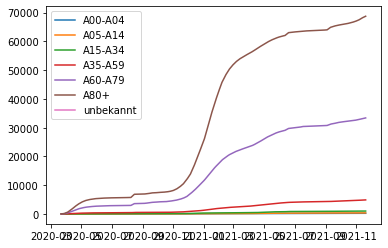

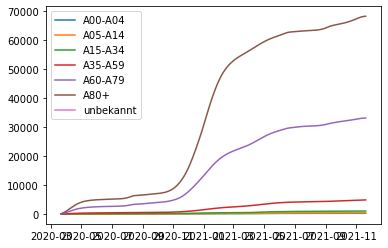

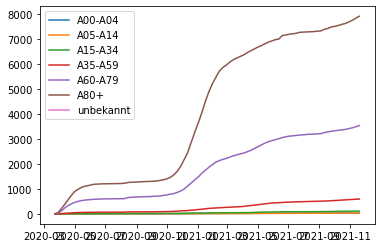

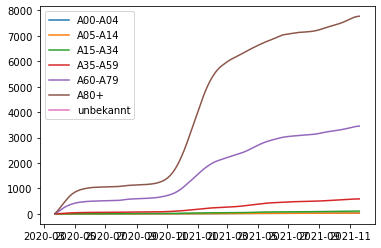

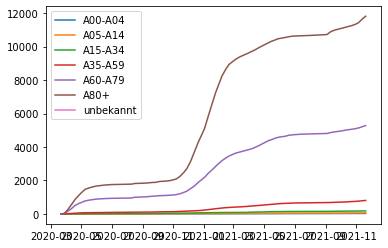

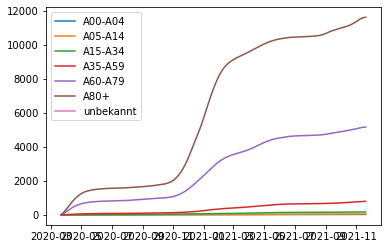

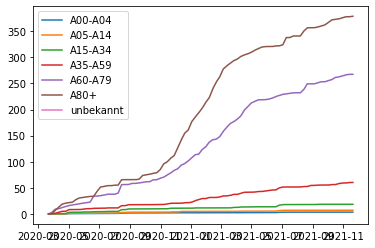

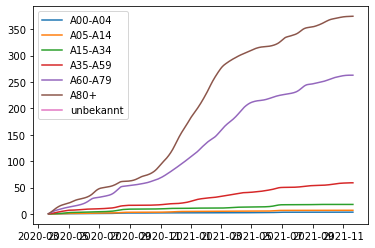

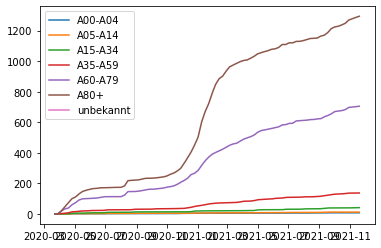

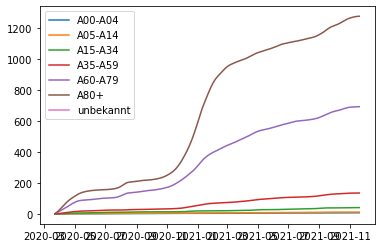

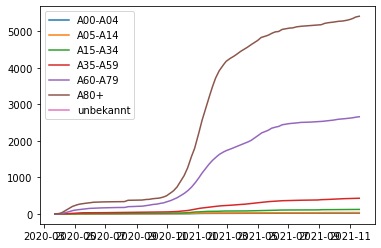

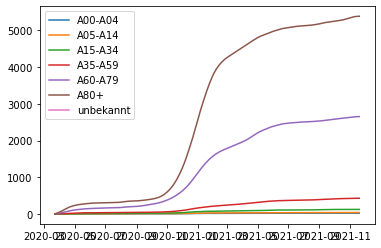

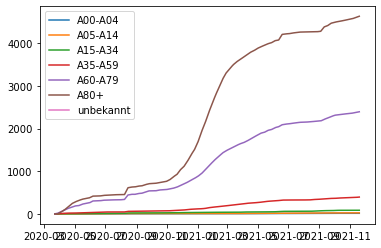

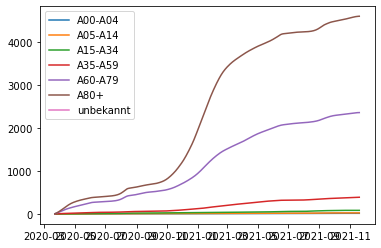

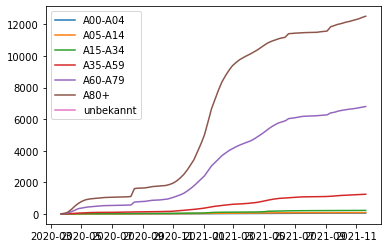

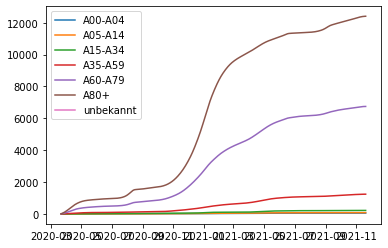

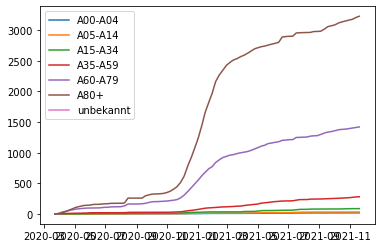

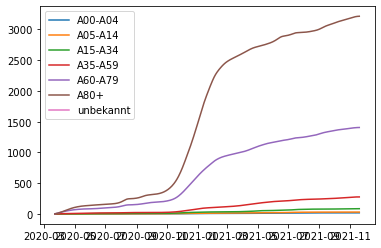

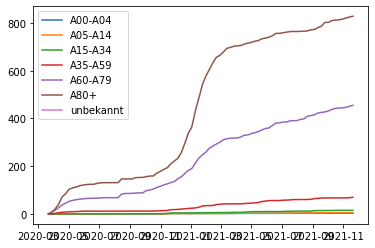

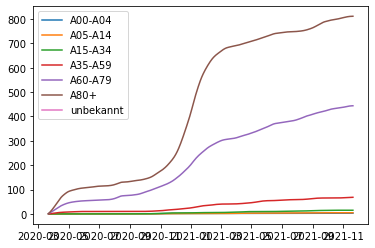

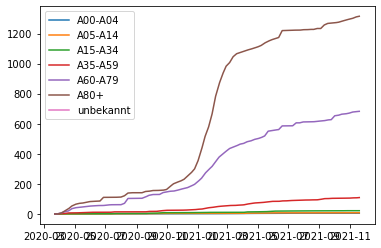

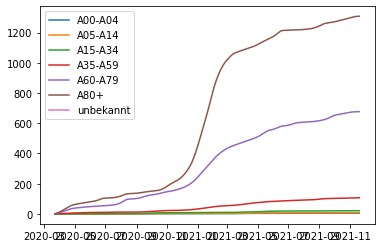

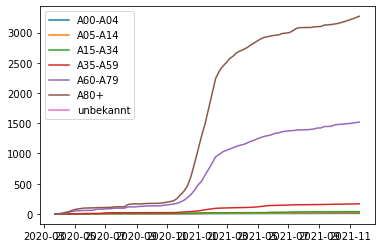

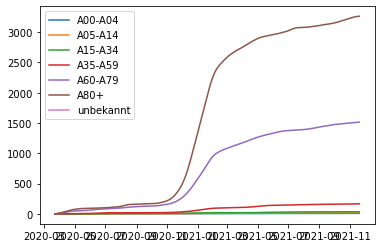

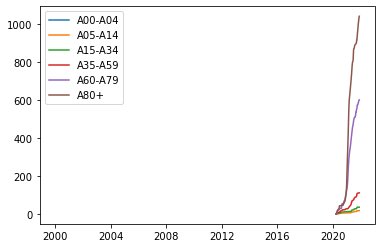

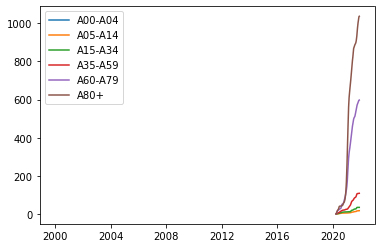

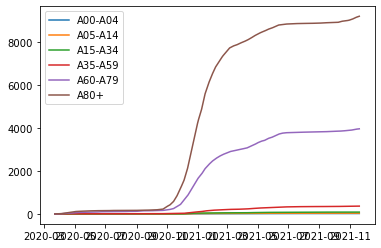

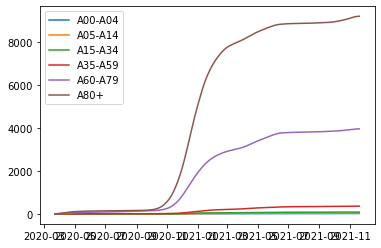

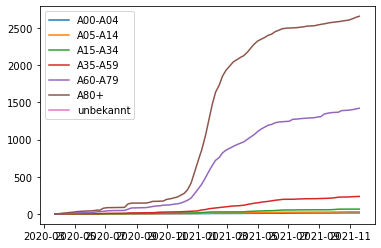

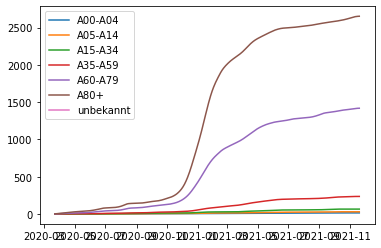

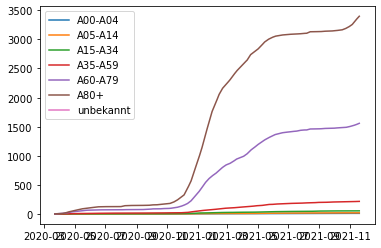

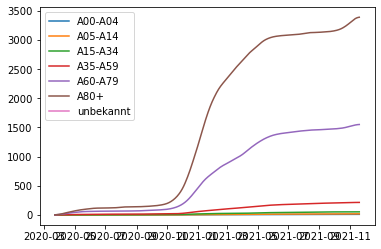

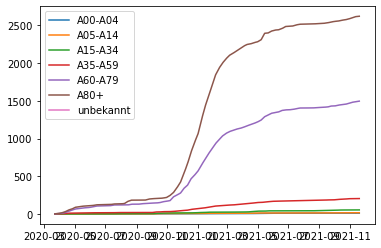

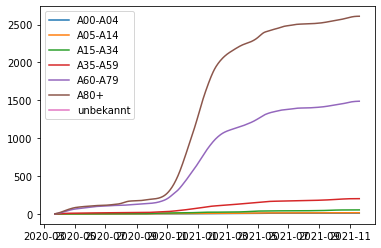

In [9]:
from module.dark_figure import DarkFigure
sim = DarkFigure(deaths, cases, total_deaths, population, prior_populations)
sim(locations)